Se adicionaron 62 (63 rows) registros de boundaries

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
# load utils
import utils as ut
import numpy as np
import scipy as sp
import scipy.stats as st
import itertools as it
pd.set_option('display.max.columns', 100)
factorsModel = ['trees', 'depth']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Carga de archivos de los resultados, los resultados estan desagregados, entre drop3 y entropy.

In [3]:
def compute_metrics (row):
    wtdAcc = 0.7*row['sensibility'] + 0.3*row['specificity']
    balancedAcc = (row['sensibility'] + row['specificity'])/2
    mcc_den = (row.tp+row.fp) * (row.tp + row.fn) * (row.tn+row.fp) * (row.tn+row.fn)
    #print(mcc_den)
    mcc = ((row.tp*row.tn) - (row.fp*row.fn))/ np.sqrt( float(mcc_den) )
    return (pd.Series([wtdAcc, balancedAcc, mcc]))

In [4]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
entropy_results_ori = ut.read_results("./data/is_experiments",  ["susyAllResults.csv"])
condition = (entropy_results_ori.isMethod != 'drop3') & (entropy_results_ori.instanceSelection != 'NOIS')
no_is_results =  entropy_results_ori[entropy_results_ori.instanceSelection == 'NOIS'].copy().reset_index(drop= True)
entropy_results = entropy_results_ori[condition].copy().reset_index(drop= True)

entropy_results[['wtdAcc', 'balancedAcc', 'mcc']] = entropy_results.apply(compute_metrics , axis = 1)
no_is_results[['wtdAcc', 'balancedAcc', 'mcc']] = no_is_results.apply(compute_metrics , axis = 1)

display(entropy_results.groupby('database')['reduction'].describe())
display(no_is_results.groupby('database')['reduction'].describe())

,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
fraudk,2700.0,0.191264,0.138268,0.014884,0.018270,0.276409,0.318203,0.319702
p2p,3079.0,0.461936,0.292289,0.040714,0.192239,0.339687,0.833308,0.910491
pageblocks,2700.0,0.606965,0.193879,0.279622,0.434302,0.544121,0.810711,0.943856


,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
fraudk,2700.0,0.191264,0.138268,0.014884,0.018270,0.276409,0.318203,0.319702
pageblocks,2700.0,0.606965,0.193879,0.279622,0.434302,0.544121,0.810711,0.943856


--- 
para adaptar los resultados de rf puro

In [5]:
# resultados de rf
# we need to keep only best parameters
# of trees and depth, for each type (train-test)
rf_p2p = pd.read_csv("data/results_no_is/confusionAll.csv")
rf_p2p['counts'] = rf_p2p.groupby(['tipo',
                'trees',
                'impurity', 
                'depth', 'bins'])['tp'].transform('count')
rf_p2p = rf_p2p[rf_p2p['counts']==5].drop('counts', axis = 1)
rf_p2p['k'] = rf_p2p.groupby([ 'trees', 'depth',  'impurity', 'bins', 'tipo']).cumcount()+1
rf_p2p = rf_p2p.sort_values(['F1', 'trees', 'depth', 'tipo', 'k'], ascending = False).drop_duplicates(['trees', 'depth', 'tipo','k'])
rf_p2p = rf_p2p.drop(['bins', 'impurity', 'PEXC', 'MCC'], axis =1).reset_index(drop = True)
rf_p2p.columns = ['type', 'tp', 'fn', 'tn', 'fp', 'sensibility', 'specificity', 'precision', 'accuracy', 'F1', 'Gmean', 'AreaROC', 'trees', 'depth', 'k']

In [6]:
rf_p2p_final = rf_p2p.copy()
rf_p2p_final[['wtdAcc', 'balancedAcc', 'mcc']] = rf_p2p_final.apply(compute_metrics, axis = 1)
rf_p2p_final['database'] = 'p2p'


In [7]:
ignore_cols = [] # ['subBuckets', 'buckAvg', 'reduction', 'buckets', 'buckMax', 'buckMin', 'timeIS', 'timeLSH']
#missing_columns = (set(no_is_results.columns) - set(rf_p2p_final.columns)) - set(ignore_cols)
missing_columns =  ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']
print("missing", missing_columns)
cols_to_complete = no_is_results[missing_columns].copy().drop_duplicates(
    ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'instanceSelection']).reset_index(drop = True)
cols_to_complete['aux'] = 1
rf_p2p_final['aux'] = 1
rf_p2p_final = pd.merge(cols_to_complete, rf_p2p_final, how = 'left', on = 'aux').drop('aux', axis = 1)

missing ['ands', 'lshMEthod', 'isMethod', 'instanceSelection', 'imbalance', 'ors']


In [8]:
no_is_results['type'] = no_is_results['type'].str.lower()
no_is_results = pd.concat([no_is_results[rf_p2p_final.columns], rf_p2p_final[rf_p2p_final.columns]], ignore_index=True)


---


Ahora todos los resultados de drop3

In [9]:
# filter out the no instance selection and drop3
# carga de dataframe para entropy
drop3_results = ut.read_results("./data/drop3",  ignore_files =  ['boundaries.csv', "one.csv", "test.csv"])

In [10]:
condition = (drop3_results.isMethod == 'drop3') & (drop3_results.instanceSelection != 'NOIS')
drop3_results = drop3_results[condition].copy().reset_index(drop= True)
# in the drop3 the file have the db and the
# one sample bucket
drop3_results[['wtdAcc', 'balancedAcc', 'mcc']] = drop3_results.apply(compute_metrics , axis = 1)
drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)

/tmp/ipykernel_31034/4191855116.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  drop3_results[['database', 'one_class_method']] = drop3_results.database.str.replace(".csv", "").str.split("_", expand = True)


Now We will concatenate the results



In [11]:
entropy_results['one_class_method'] = 'entropy'
drop3_entropy = pd.concat([entropy_results, drop3_results], ignore_index=True)
# deduplicate records
drop3_entropy = drop3_entropy.drop_duplicates()

In [12]:
## add axiliary results        
drop3_entropy['Total Time'] = drop3_entropy.timeLSH + drop3_entropy.timeIS
drop3_entropy['total'] = drop3_entropy.tp + drop3_entropy.tn + drop3_entropy.fn + drop3_entropy.fp
drop3_entropy['samples by bucket average (relative)'] = drop3_entropy.buckAvg/drop3_entropy.total*100.0
drop3_entropy['model_complexity'] =  drop3_entropy.trees*drop3_entropy.depth
drop3_entropy['Reduction of DataSet(%)'] = (1 - drop3_entropy['reduction'])*100.0
drop3_entropy['type'] = drop3_entropy['type'].str.lower()

# Adapt the dataframes to plots

In [13]:
cols_to_dedup = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'k', 'type', 'instanceSelection'] + factorsModel

In [14]:
measuresNoIS = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 
                'accuracy', 'F1', 'Gmean', 'wtdAcc','AreaROC', 'balancedAcc', 'mcc']
factorsNoIS = ['database']
cols_to_dedup_noIs = ['ands', 'database', 'k', 'type'] +factorsModel


no_is_results_dp =  no_is_results.drop_duplicates(subset = cols_to_dedup_noIs)


best_no_is = (no_is_results_dp.groupby(factorsNoIS)
                .apply(lambda g : ut.get_best_for(g, 
                measuresNoIS, 
                measure_sort = 'Gmean', 
                factorsModel = factorsModel, 
                debug = False, 
                agg=False))
                .reset_index())


best_no_is['model_complexity'] =  best_no_is.trees*best_no_is.depth

In [15]:
ands = no_is_results.ands.unique()
dfs = []
for a in ands:
    df_partial = best_no_is.copy()
    df_partial['ands'] = a
    dfs.append(df_partial)
best_no_is = pd.concat(dfs, ignore_index=True)

In [16]:
display(no_is_results_dp[no_is_results_dp.database=='pageblocks'].k.unique())
display(no_is_results_dp[no_is_results_dp.database=='fraudk'].k.unique())
display(no_is_results_dp[no_is_results_dp.database=='p2p'].k.unique())

array([1, 2, 3, 4, 5])

array([1, 2, 3, 4, 5])

array([2, 5, 1, 3, 4])

In [17]:
display(best_no_is[best_no_is.database=='pageblocks'].k.unique())
display(best_no_is[best_no_is.database=='fraudk'].k.unique())
display(best_no_is[best_no_is.database=='p2p'].k.unique())

array([1, 2, 3, 4, 5])

array([1, 2, 3, 4, 5])

array([2, 1, 5, 3, 4])

In [18]:
drop3_entropy.drop_duplicates(cols_to_dedup).groupby(['database', 
                        'instanceSelection',
                        'imbalance', 
                        'lshMEthod']+ factorsModel)['tp'].count()

database    instanceSelection  imbalance  lshMEthod    trees  depth
fraudk      IS                 False      hyperplanes  10     10        50
                                                              20        50
                                                              30        50
                                                       25     10        50
                                                              20        50
                                                                      ... 
pageblocks  IS                 True       projection   25     20       100
                                                              30       100
                                                       50     10       100
                                                              20       100
                                                              30       100
Name: tp, Length: 162, dtype: int64

In [19]:
drop3_entropy[drop3_entropy.imbalance==True].drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'k': ['unique'],  'trees': 'unique', 'depth': 'unique'})

tp  \
                                                                     count   
database   instanceSelection one_class_method lshMEthod                      
fraudk     IS                boundaries       hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
                             entropy          hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
                             one              hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
p2p        IS                boundaries       hyperplanes              257   
                                              hyperplanes-projection   234   
                                              projection               216   
                             entropy          hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
                             one              hyperplanes              322   
                                              hyperplanes-projection   300   
                                              projection               288   
pageblocks IS                boundaries       hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
                             entropy          hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   
                             one              hyperplanes              450   
                                              hyperplanes-projection   450   
                                              projection               450   

                                                                                  ands  \
                                                                                unique   
database   instanceSelection one_class_method lshMEthod                                  
fraudk     IS                boundaries       hyperplanes             [6, 8, 10, 2, 4]   
                                              hyperplanes-projection  [6, 8, 10, 2, 4]   
                                              projection              [6, 8, 10, 2, 4]   
                             entropy          hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             one              hyperplanes             [6, 8, 10, 2, 4]   
                                              hyperplanes-projection  [6, 8, 10, 2, 4]   
                                              projection              [6, 8, 10, 2, 4]   
p2p        IS                boundaries       hyperplanes             [6, 2, 4, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             entropy          hyperplanes             [2, 4, 6, 8, 10]   
                                              hyperplanes-projection  [2, 4, 6, 8, 10]   
                                              projection              [2, 4, 6, 8, 10]   
                             one              hyperplanes             [2, 4, 6, 8, 10]   
                     

In [21]:
drop3_entropy[drop3_entropy.imbalance==True].drop_duplicates(cols_to_dedup +[ 'one_class_method']).groupby(['database', 
                        'instanceSelection',
                        'one_class_method',
                        'k',
                        'lshMEthod']).agg({'tp': 'count', 'ands': 'unique', 'trees': 'unique', 'depth': 'unique'}).to_excel("check.xlsx")

In [22]:
factorsIS = ['lshMEthod', 'ands', 'imbalance', 'isMethod', 'database', 'one_class_method']

measures = ['tp', 'tn', 'fp', 'fn', 'sensibility','specificity', 'precision', 'accuracy', 'F1', 
'Gmean','wtdAcc', 'balancedAcc', 'mcc','AreaROC', 'timeIS', 'timeLSH', 'model_complexity', 'Total Time', 'Reduction of DataSet(%)']

In [23]:
drop3_entropy.one_class_method.unique()

array(['entropy', 'one', 'boundaries'], dtype=object)

In [24]:
drop3_entropy['database'].unique()

array(['pageblocks', 'p2p', 'fraudk'], dtype=object)

In [25]:
drop3_entropy.one_class_method.unique()

array(['entropy', 'one', 'boundaries'], dtype=object)

In [26]:
drop3_entropy.lshMEthod.unique()

array(['hyperplanes', 'projection', 'hyperplanes-projection'],
      dtype=object)

## the actual plots

In [27]:
db_map = {'fraudk': 'credit_card', 'p2p':'gateway_credit_card', 'pageblocks': 'pageblocks'}
is_map = {'entropy': 'entropy', 'boundaries':'drop3-boundaries', 'one': 'drop3-one'}
lsh_map = {'hyperplanes': 'RHF', 'projection':'DPF', 'hyperplanes-projection': 'RHF+DPF'}

In [54]:
best_no_is['database']= best_no_is.database.map(db_map)

In [28]:
d = drop3_entropy.copy()
d['total'] = d.tp+d.tn+d.fp+d.fn+d.fn
d =  d[d.type=='test'].groupby(['database', 'lshMEthod', 'one_class_method', 'ands', 'trees', 'depth'])[['Gmean', 'total']].mean().reset_index()
d.sort_values('Gmean', ascending = False).drop_duplicates(subset= 'database')

,database,lshMEthod,one_class_method,ands,trees,depth,Gmean,total
94,fraudk,hyperplanes,one,2,25,20,93.767056,56499.0
942,pageblocks,hyperplanes,one,10,50,10,93.321654,1098.8
512,p2p,hyperplanes,one,4,50,30,90.274275,1291002.0


In [29]:
checking = drop3_entropy.copy()
checking['total'] = checking.tp + checking.tn + checking.fp + checking.fn
checking['other'] = checking.lshMEthod.astype('str') + checking.ands.astype('str') + checking.trees.astype('str') + checking.depth.astype('str')

In [30]:
t = checking[checking.type == 'test'].groupby(['database', 'other'])['total'].agg(['min', 'max']).reset_index()

In [31]:
t[t.database == 'fraudk']

,database,other,min,max
0,fraudk,hyperplanes-projection101010,56723.0,57419.0
1,fraudk,hyperplanes-projection101020,56721.0,57425.0
2,fraudk,hyperplanes-projection101030,56723.0,57421.0
3,fraudk,hyperplanes-projection102510,56726.0,57420.0
4,fraudk,hyperplanes-projection102520,56725.0,57421.0
...,...,...,...,...
130,fraudk,projection82520,56726.0,57422.0
131,fraudk,projection82530,56727.0,57420.0
132,fraudk,projection85010,56726.0,57419.0
133,fraudk,projection85020,56725.0,57421.0


In [32]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method']).reset_index(drop = True)

results_dedup['database'] = results_dedup.database.map(db_map)
results_dedup.one_class_method = results_dedup.one_class_method.map(is_map)

results_dedup['lshMEthod'] = results_dedup.lshMEthod.map(lsh_map)

In [33]:
d = results_dedup.copy()
d['total'] = d.tp+d.tn+d.fp+d.fn+d.fn
d =  d[d.type=='test'].groupby(['database', 'lshMEthod', 'one_class_method', 'ands'])[['Gmean', 'total']].mean().reset_index()
d.sort_values('Gmean', ascending = False).drop_duplicates(subset= 'database')

,database,lshMEthod,one_class_method,ands,Gmean,total
20,credit_card,RHF,drop3-one,2,92.744723,5.662136e+04
114,pageblocks,RHF,drop3-one,10,92.721393,1.063733e+03
65,gateway_credit_card,RHF,drop3-one,2,87.757428,1.288699e+06


In [34]:
cond = results_dedup.imbalance == True

df_toplot = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures + ['reduction'], measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())

display(df_toplot.groupby('database')['reduction'].describe())
df_toplot['db/IS_Method'] = df_toplot.database + "/\n" +  df_toplot.one_class_method
df_toplot['% of samples'] = df_toplot.reduction*100

,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
credit_card,450.0,0.401270,0.399931,0.004526,0.025560,0.306653,0.931054,0.970625
gateway_credit_card,326.0,0.398110,0.351891,0.002988,0.116542,0.242783,0.837370,0.958308
pageblocks,450.0,0.574489,0.319209,0.113647,0.281835,0.571753,0.890105,0.992241


In [35]:
display(results_dedup.groupby('database')['reduction'].describe())
display(df_toplot.groupby('database')['% of samples'].describe())

,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
credit_card,5400.0,0.348529,0.363891,0.004522,0.020806,0.298046,0.761509,0.970625
gateway_credit_card,4317.0,0.422784,0.330559,0.002977,0.134186,0.318874,0.833362,0.959969
pageblocks,5400.0,0.584843,0.293892,0.113419,0.369556,0.576249,0.874055,0.994067


,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
credit_card,450.0,40.126971,39.993065,0.452634,2.555998,30.665287,93.105413,97.062491
gateway_credit_card,326.0,39.810977,35.189063,0.298814,11.654169,24.278293,83.736977,95.830834
pageblocks,450.0,57.448908,31.920873,11.364674,28.183478,57.175295,89.010488,99.224099


In [36]:
r = best_no_is.copy()
r['total'] = r.tp+r.tn+r.fp+r.fn+r.fn
r[r.type == 'train'].groupby('database')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
fraudk,125.0,228238.04,243.123406,227911.0,227976.0,228408.0,228420.0,228475.0
p2p,125.0,4870185.00,498.419680,4869414.0,4869786.0,4870485.0,4870549.0,4870691.0
pageblocks,125.0,4816.88,40.293600,4768.0,4782.0,4816.0,4835.0,4886.0


In [37]:
l = df_toplot.copy()
l['total'] = l.tp+l.tn+l.fp+l.fn+l.fn
display(l[(l.reduction<0.009) & (l.type == 'train')].groupby(['database'])['total'].describe())
display(l[(l.reduction<0.009) & (l.type == 'train')].groupby(['database'])['reduction'].describe())

,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
credit_card,20.0,1501.70,77.254262,1420.0,1441.75,1469.5,1535.25,1647.0
gateway_credit_card,25.0,24677.28,7886.191939,19278.0,19432.00,19669.0,31964.00,40343.0


,count,mean,std,min,25%,50%,75%,max
database,,,,,,,,
credit_card,20.0,0.004865,0.000337,0.004526,0.004612,0.004725,0.004997,0.005503
gateway_credit_card,25.0,0.004025,0.001518,0.002988,0.003017,0.003061,0.005431,0.007042


In [98]:
def plot_9_results (df_in, df_reference, measure = 'Gmean', measure_for_best = 'Gmean', aspect=2, height=8):

    linewidth =  5
    col_order = ['credit_card/\nentropy', 'credit_card/\ndrop3-boundaries', 'credit_card/\ndrop3-one',
                'pageblocks/\nentropy', 'pageblocks/\ndrop3-boundaries', 'pageblocks/\ndrop3-one',
                'gateway_credit_card/\nentropy', 'gateway_credit_card/\ndrop3-boundaries', 'gateway_credit_card/\ndrop3-one']
    
    bar_params =  {'ci' : 95,
                  'err_style' :  'bars', 
                  'err_kws': {'capsize': 10.0, 'elinewidth': linewidth*1.1} }
    
    common = {'data' : df_in[df_in.type=='test'],
                    'x' : 'ands', 
                    'y' : measure, 
                    'style' : 'lshMEthod', 
                    'hue' : 'lshMEthod', 
                    'col' : 'db/IS_Method',
                    'col_wrap': 3,
                    'linewidth' : linewidth,
                   
                    'col_order' : col_order,
                    'kind' : 'line', 
                    'aspect' : aspect,
                    'height' : height,
                    'facet_kws' : {'sharey': 'row'},
                   }
    
    common.update(bar_params)
    
    gg = sns.relplot(**common, legend = True)
    
    leg = gg._legend
    
    g = sns.relplot(**common, legend = False)
    
    if df_reference is not None:
        # add reference
        axs  = np.ravel (g.axes)
        for ax in np.ravel(axs):
            db = ut.get_db_from_ax(ax).split("/")[0]
            mea_test = df_reference.loc[(df_reference.database==db) & (df_reference.type == 'test'), ['ands', measure]].copy()
            print("reference", db,  mea_test.shape)
            mea_test['Baseline'] = 'Baseline'
            if len(mea_test) > 0:
                xx = sns.lineplot(data=mea_test,
                                  x="ands", 
                                  y=measure, 
                                  ax = ax, 
                                  dashes = [(2, 2)],
                                  style = 'Baseline',
                                  palette = [(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)], 
                                  legend = False, 
                                  linewidth =linewidth,
                                  hue = 'Baseline',
                                  **bar_params)
    
        current_labels = [label.get_text() for label in leg.texts] + ['Baseline']
        # get the line of the reference
        current_handlers = leg.legendHandles + [ax.lines[-4]]
        dict_legend = {label: handler for label,handler in zip (current_labels, current_handlers) }
        g.fig.subplots_adjust(wspace=0.1, hspace=0.1, top = 1.0 )
        
        g.add_legend(dict_legend, bbox_to_anchor=(0.18, 1.1,1.0, 0.03), loc='upper left', adjust_subtitles = True,
                     ncol=5, mode=None, borderaxespad=0.5, fontsize = 28, borderpad = 0.8)
        for line in g._legend.get_lines():
            line.set_linewidth(linewidth+0.5)    
    #plt.tight_layout()
    g.set_titles(col_template="{col_name}", fontsize = 40)
    g.savefig(f"report/{measure}.png", dpi = 300,  bbox_inches='tight',  bbox_extra_artists=(g._legend,))
    g.set(xlabel='ANDS')
    return(g, dict_legend)

reference credit_card (125, 2)
reference credit_card (125, 2)
reference credit_card (125, 2)
reference pageblocks (125, 2)
reference pageblocks (125, 2)
reference pageblocks (125, 2)
reference gateway_credit_card (125, 2)
reference gateway_credit_card (125, 2)
reference gateway_credit_card (125, 2)


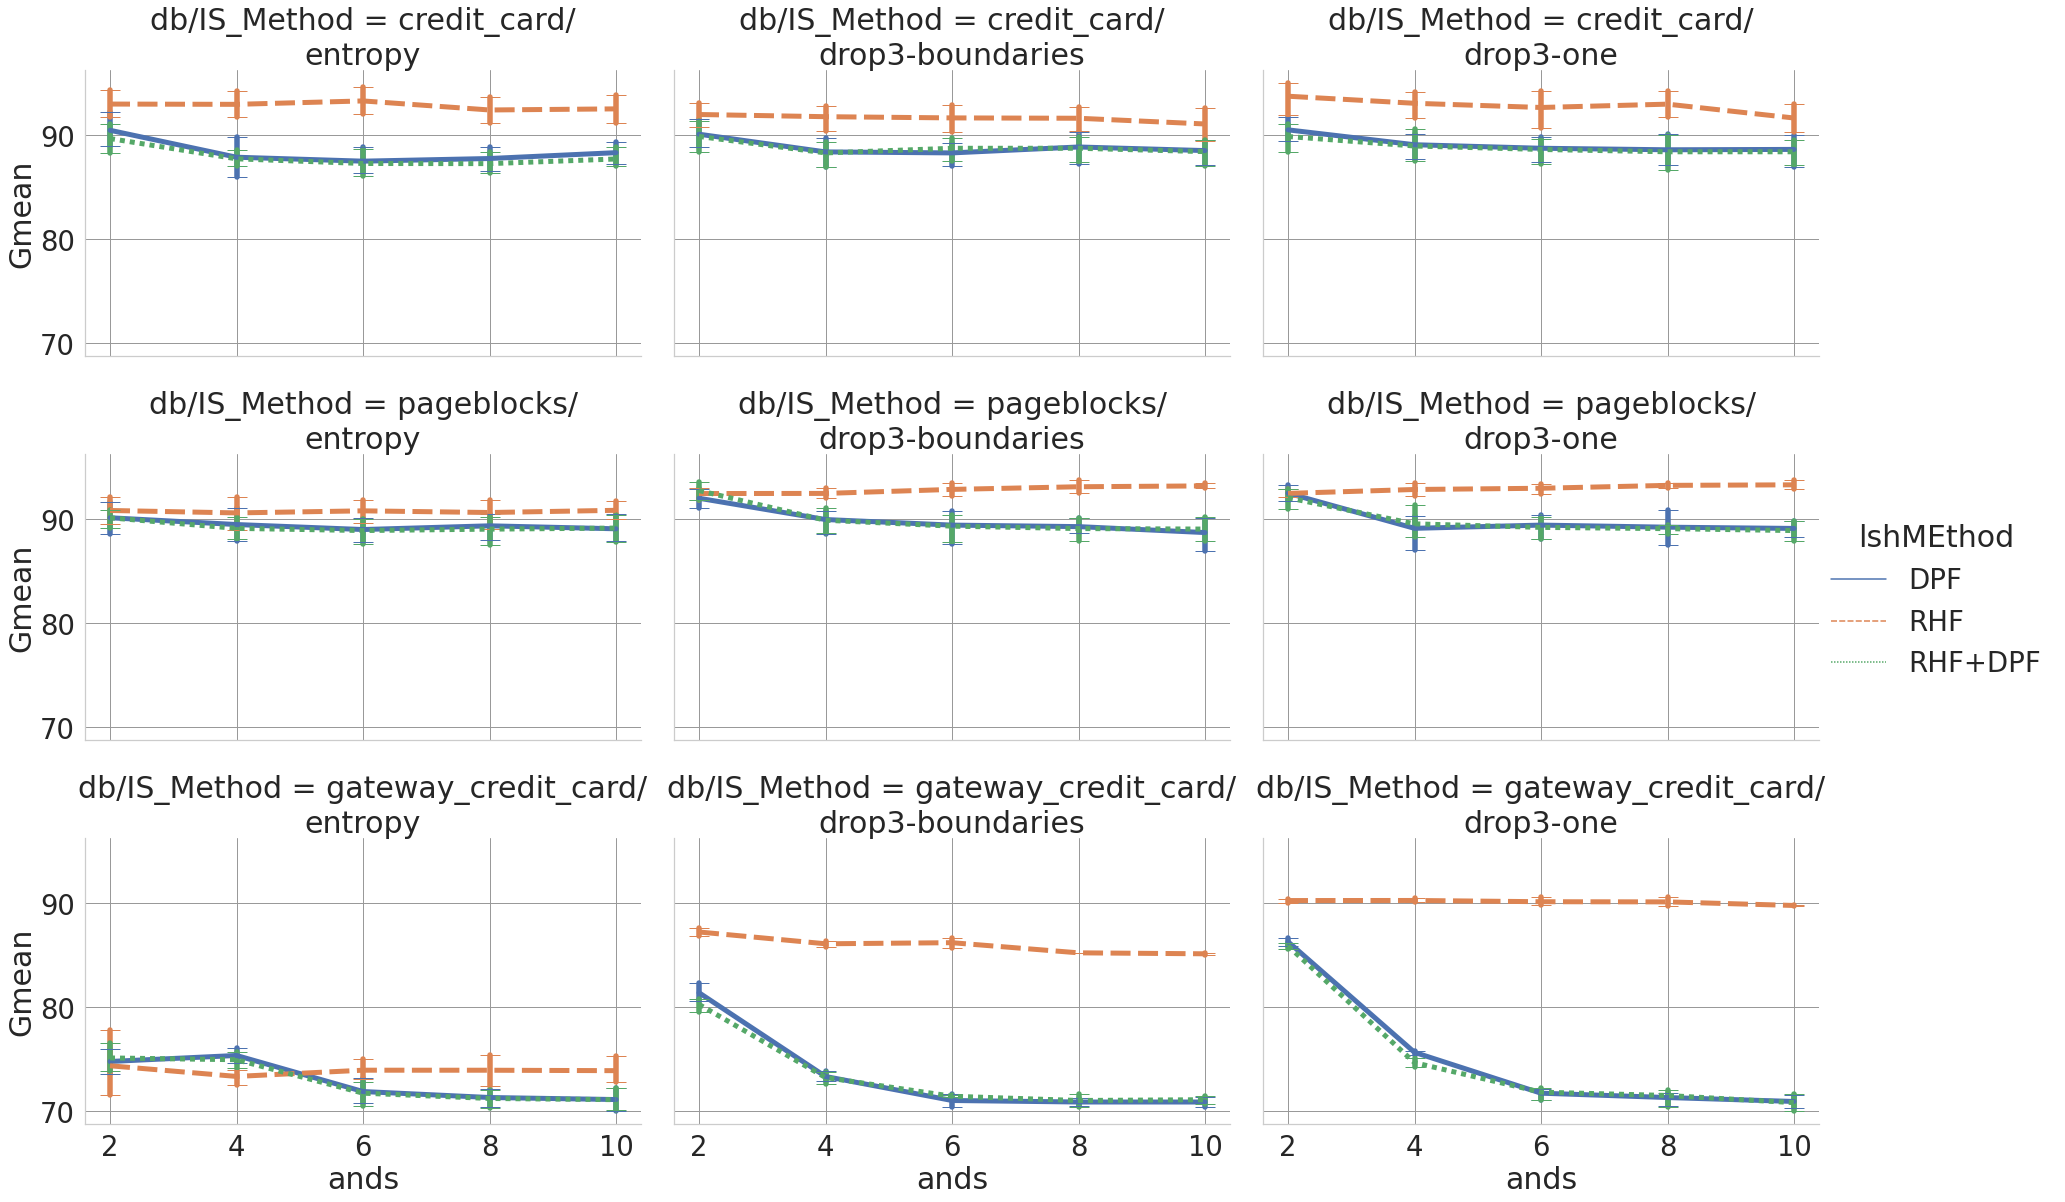

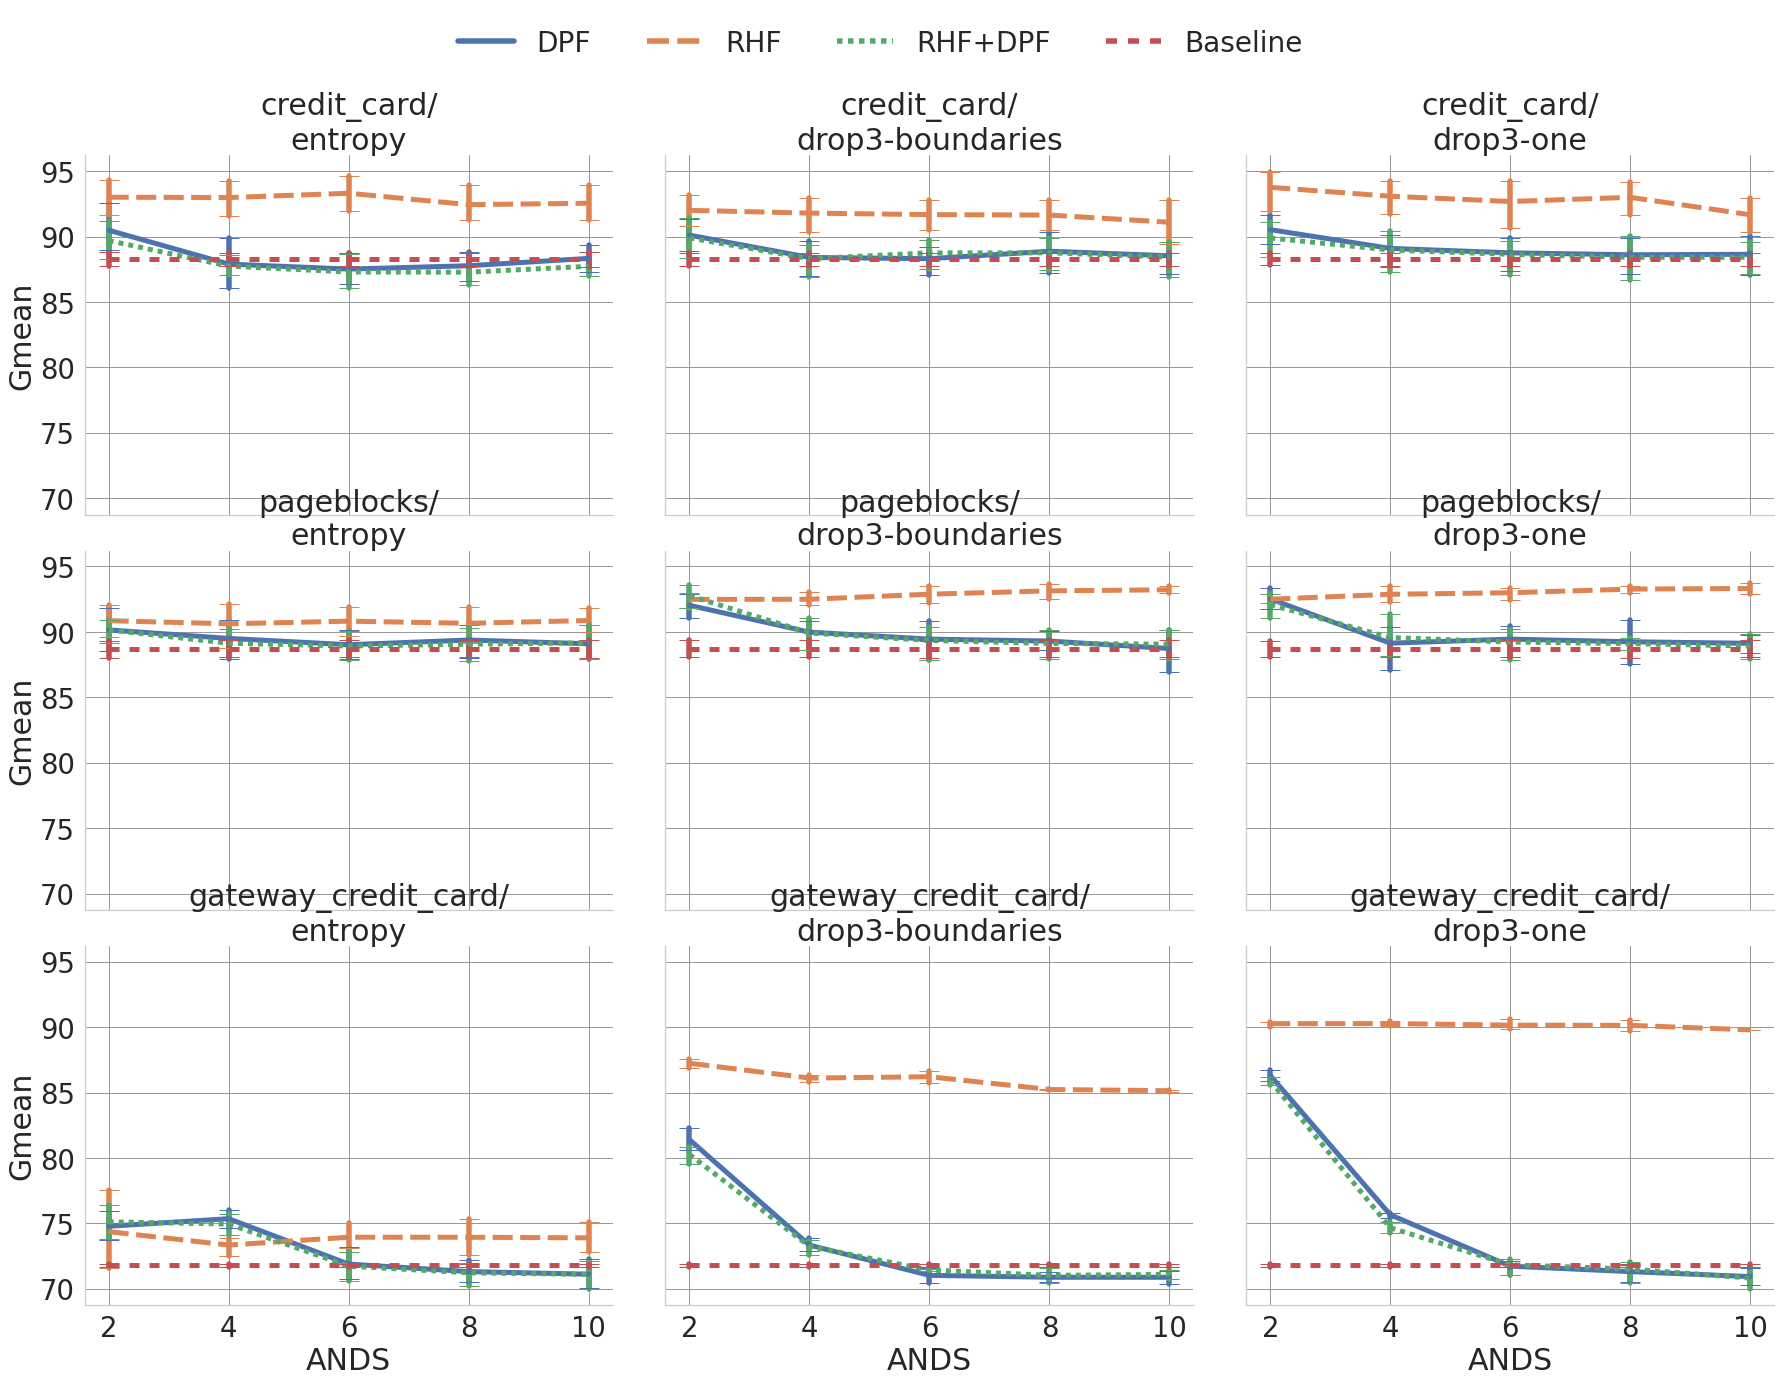

In [99]:
sns.set(font_scale=2.5, style='whitegrid',
        rc={'grid.color': '.6'})

g,_ = plot_9_results(df_in = df_toplot, df_reference = best_no_is, measure= 'Gmean', measure_for_best='Gmean', aspect =1.5, height=5.8)

# Table Generation

In [39]:
def to_mean_std_cell(df, cols_only_mean = ['model_complexity']):
    columns = list(df.columns)
    table = pd.DataFrame()
    idx = 0
    for c in range(int(len(columns)/2)):
        if columns[c+idx][0] not in cols_only_mean:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str') + " +- " +  df[columns[c+idx+1]].astype('str')
        else:
            table[columns[c+idx][0]] = df[columns[c+idx] ].astype('str')
        idx+=1
    return(table)

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [40]:
order_cols = ['sensibility', 'specificity', 'F1', 'Gmean', 'balancedAcc', 
              'mcc','Reduction of DataSet(%)', 'model_complexity']

cols_to_ignore = ['timeIS', 'timeLSH', 'Total Time', 
                  'level_6', 'imbalance', 'trees','depth',
                  'tp', 'tn', 'fp', 'fn', 'precision', 'accuracy',
                  'wtdAcc', 'AreaROC', 'precision']

In [41]:
results_dedup = drop3_entropy.drop_duplicates(cols_to_dedup +[ 'one_class_method'])
cond= results_dedup.imbalance == True

In [42]:
to_table = (results_dedup[cond].groupby(factorsIS)
                .apply(lambda g : ut.get_best_for(g, measures, measure_sort = 'Gmean', factorsModel = factorsModel))
                .reset_index())
to_table = to_table[to_table.type=='test'].drop(cols_to_ignore, axis = 1)
to_table['isMethod'] = to_table['isMethod'] + "-" + to_table['one_class_method'] 
to_table= to_table.groupby(['database','lshMEthod', 'isMethod', 'ands']).agg(['mean', 'std']).round(2)
table = to_mean_std_cell(to_table)[order_cols]

In [43]:
factorsNOIS = ['database','lshMEthod', 'isMethod', 'ands',]
best_no_is_table = best_no_is.copy()
best_no_is_table['lshMEthod'] = 'NoIS'
best_no_is_table['isMethod'] = 'NoIS'
best_no_is_table['ands'] = 'NoIS'
table_reference =( best_no_is_table[best_no_is_table.type == 'test']
                  .drop(cols_to_ignore + ['level_1', 'k'], axis = 1, errors='ignore')
                  .groupby(factorsNOIS)
                  .agg(['mean', 'std'])
                  .round(2))
table_reference = to_mean_std_cell(table_reference)

In [44]:
def get_final_table(reference, is_table, db):
    db_table = pd.concat([reference.loc[[i for i in reference.index if db in i], :], 
                          is_table.loc[[i for i in is_table.index if db in i], :]])
    return(db_table.fillna("--"))

db = results_dedup.database.unique()
with pd.ExcelWriter('table.xlsx') as writer:
    get_final_table(table_reference, table, db[0]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[0])
    get_final_table(table_reference, table, db[1]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[1])
    get_final_table(table_reference, table, db[2]).style.apply(highlight_max, axis = 0).to_excel(writer, sheet_name=db[2])

# Hypothesis Testing

Now we will asses if there is difference among the methods and their configurations and see the rankings

In [100]:
import itertools
metric= 'Gmean'
ismet = df_toplot.one_class_method.unique()
lsh = df_toplot.lshMEthod.unique()
ands = df_toplot.ands.unique()

In [101]:
def friedman_test(*args, alpha = 0.05):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        # get the ranks
        ranks = [row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row]
        #print("row", row, "ranks", ranks)
        rankings.append(ranks)

    # average of rankings
    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - st.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    print(f"p={p_value:.6F}")

    if p_value > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

    return iman_davenport, p_value, rankings_avg, rankings_cmp

In [102]:
combinations = list(itertools.product(ismet, lsh))
data_list = [df_toplot.loc[
    (df_toplot.one_class_method ==  is_lsh_and[0]) 
    & (df_toplot.lshMEthod ==  is_lsh_and[1]) 
    & (df_toplot.type=='test'), metric].values for is_lsh_and in combinations]

data_list_count = [len(c) for c in data_list]
min(data_list_count)

f, p, ranks, pivot = friedman_test(*[c[0:min(data_list_count)] for c in data_list])

ranks_df = pd.DataFrame(columns = ['is_method', "lsh", "rank"])
for i,c in enumerate(combinations):
    is_m, lsh_f = c
    ranks_df.loc[i, :] = [is_m, lsh_f,ranks[i]]
#g = sns.catplot(data=ranks_df, hue = "is_method", y = 'lsh', x = 'rank', kind = 'bar', aspect = 2, orient = 'h')
#g.ax.set_title("No ands")

p=0.000000
Different distributions (reject H0)


comparasion including the ands

In [234]:
combinations = list(itertools.product(ismet, lsh, ands))
data_list = [df_toplot.loc[
    (df_toplot.one_class_method ==  is_lsh_and[0]) 
    & (df_toplot.lshMEthod ==  is_lsh_and[1])
    & (df_toplot.ands ==  is_lsh_and[2])
    & (df_toplot.type=='test'), metric].values for is_lsh_and in combinations]

data_list_count = [len(c) for c in data_list]
min(data_list_count)

f, p, ranks, pivot = friedman_test(*[c[0:min(data_list_count)] for c in data_list])

ranks_df = pd.DataFrame(columns = ['is_method', "lsh", "ands", "rank"])
for i,c in enumerate(combinations):
    is_m, lsh_f, a_f = c
    ranks_df.loc[i, :] = [is_m, lsh_f,a_f, ranks[i]]

p=0.000000
Different distributions (reject H0)


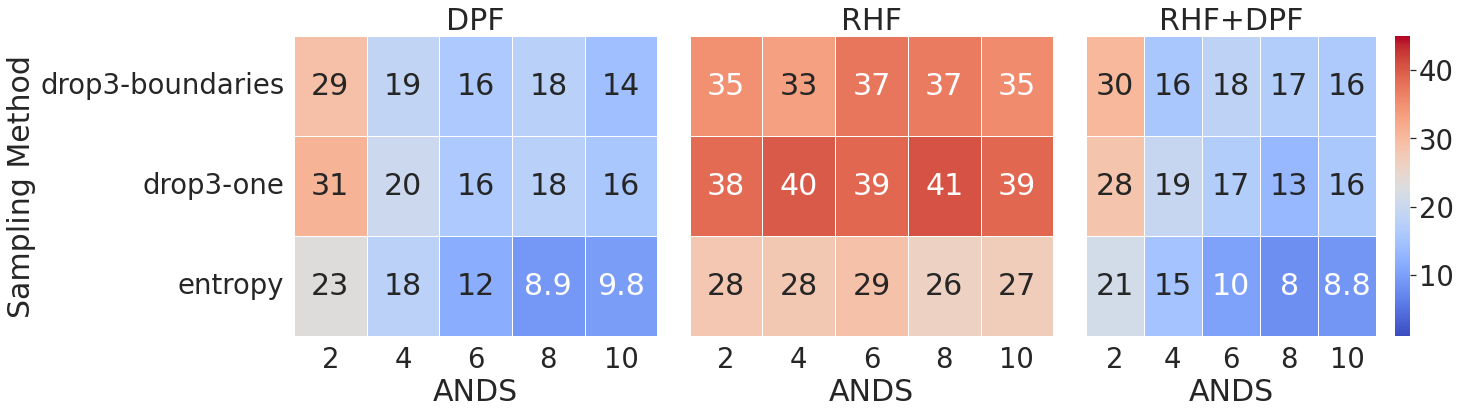

In [232]:
mapping = {'drop3-boundaries': 0, 'drop3-one': 1, 'entropy': 2}
c_bar_mapping = {'DPF': False, 'RHF': False, 'RHF+DPF': True}

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    col = data.lsh.unique()[0]
    d = pd.pivot_table(data, index=args[1], columns=args[0], values=args[2], aggfunc= 'first')
    cbar = c_bar_mapping[col]
    sns.heatmap(d, cbar = cbar, **kwargs)

ranks_df['IS Method'] = ranks_df.is_method
ranks_df['ANDS'] = ranks_df.ands
    
fg = sns.FacetGrid(ranks_df, col='lsh', aspect = 1, height=7)
fg.map_dataframe(draw_heatmap, 'ANDS', 'IS Method', 'rank', cmap = 'coolwarm', annot = True, vmin = 1.0, vmax=45,  linewidths=.5)
fg.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
fg.set_titles(col_template="{col_name}")
fg.set_ylabels("Sampling Method")
fg.savefig(f"report/rank_test.png", dpi = 300)

In [235]:
print(f"Ranks for friedman test\n with p-value: {p:.4F} and F-value = {f:.4F}")

Ranks for friedman test
 with p-value: 0.0000 and F-value = 14.3003


make the compararsion with the reference method

First we will use Kruskal-Wallis H Test to detemrine if there is evidence that we have real differences among the methods:
1. separate the groups in LSH for all datasets and reference for all datasets
2. test if there is difference

In [107]:
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare

def kruskal_test (data_list, alpha = 0.05):
    
    stat, p = kruskal(*data_list)
    print('Statistics=%.6f, p=%.6f' % (stat, p))
    # interpret
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    return (stat,p)


In [108]:
stat_kt, p_kt = kruskal_test([best_no_is.loc[best_no_is.type=='test', 'Gmean'], df_toplot.loc[df_toplot.type=='test', 'Gmean']])

Statistics=92.598098, p=0.000000
Different distributions (reject H0)


In [109]:
from scipy.stats import wilcoxon
ref = best_no_is.drop_duplicates(["database", "k", "type"])
ref = ref.loc[(ref.type == 'test'), ['database', 'k', metric]].copy()

In [110]:
pairwise_comp = pd.DataFrame(columns = ['is_method', "lsh", "ands", "p", "conclusion", "statistic", "avg", "avg_ref","is_win"])
alpha = 0.05
for i,c in enumerate(combinations):
	is_m, lsh_f, a_f = c
	condition = ( (df_toplot.ands==a_f)
				& (df_toplot.one_class_method==is_m) 
				& (df_toplot.lshMEthod==lsh_f)
				& (df_toplot.type=="test") )

	first = df_toplot.loc[condition,   ['database', 'k', metric]].copy()
	#print ("shape is", first.shape)
	ref_adj = pd.merge(ref, first.drop(metric, axis = 1), on = ['database', 'k'])
	#print ("shape is", ref_adj.shape)
	stat, p = wilcoxon(ref_adj[metric], first[metric])
	avg_met = first[metric].mean()
	avg_ref = ref_adj[metric].mean()
	is_diff_dist = p <= alpha
	is_win = (avg_met>avg_ref )and (is_diff_dist)
	pairwise_comp.loc[i, :] = [is_m, lsh_f,a_f, p, is_diff_dist , stat, avg_met, avg_ref, is_win]

pairwise_comp= pairwise_comp.convert_dtypes()

/home/german/venv/general_analysis/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [113]:
from statsmodels.stats.multitest import multipletests
conclusion_corr, p_corr, _, _ = multipletests(pairwise_comp.p, method = 'holm')
pairwise_comp['p_corr'] = p_corr
pairwise_comp['conclusion_corr'] = conclusion_corr
pairwise_comp['p_corr_win'] = pairwise_comp.apply(lambda r: r.p_corr if (r['avg']>r['avg_ref'])  else np.nan, axis = 1)

pairwise_comp['is_win_corr'] = (pairwise_comp['conclusion_corr']) &  (pairwise_comp['avg']>pairwise_comp['avg_ref']) 

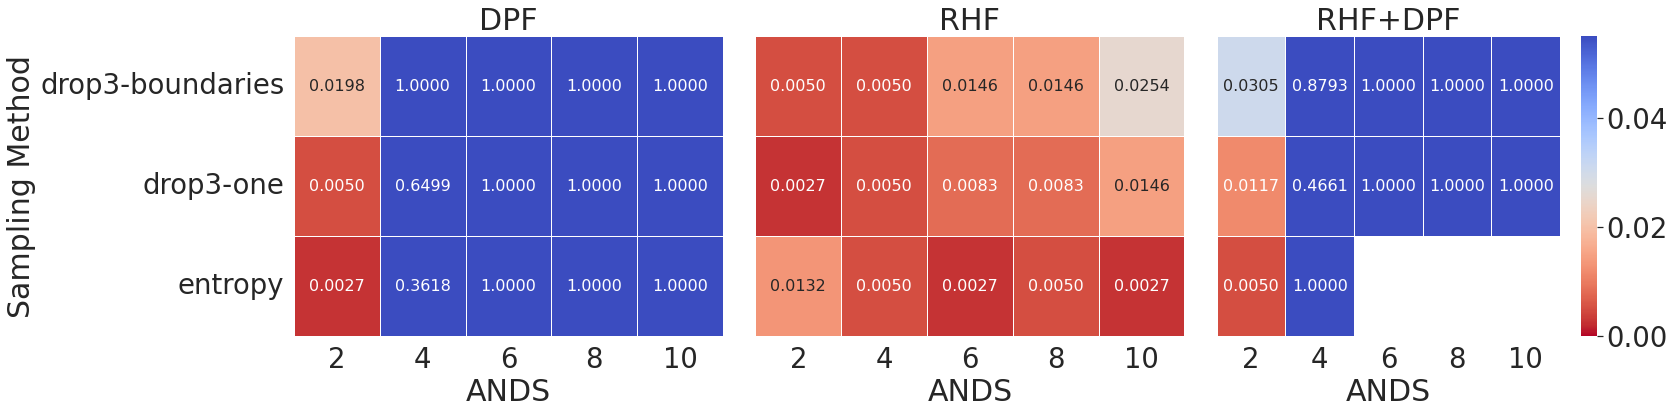

In [229]:
# results of pairwise compararion with reference
pairwise_comp['IS Method'] = pairwise_comp.is_method
pairwise_comp['ANDS'] = pairwise_comp.ands

fg = sns.FacetGrid(pairwise_comp, col='lsh', aspect = 1, height=8)
fg.map_dataframe(draw_heatmap, 'ANDS', 'IS Method', 'p_corr_win', cmap = 'coolwarm_r', annot = True, vmin = 0.0, vmax=0.055,  linewidths=.5, fmt = '.4f', annot_kws = {'fontsize':16})
fg.fig.subplots_adjust(top=0.7) # adjust the Figure in rp

fg.set_titles(col_template="{col_name}")
fg.set_ylabels("Sampling Method")
fg.savefig(f"report/pair_comp.png", dpi = 300)

In [115]:
comp = pairwise_comp.groupby(['is_method', "lsh"]).agg({'is_win_corr': 'sum', 'avg_ref': 'mean', 'avg': 'mean'}).reset_index()

In [116]:
winners = comp.loc[comp.is_win_corr>=2.0, ["is_method", "lsh"]].values
#winners  = list(itertools.combinations(winners, 2))
#winners

In [ ]:
pairwise_winners = pd.DataFrame(columns = ['method1', 'method2' , "ands", "p", "winner", "statistic", "avg_ref1", "avg_ref2"])
alpha = 0.05
i = 0
for w1 in winners:
    for w2 in winners:
        is_met_comb = (w1, w2)
        ref1_is, ref1_lsh = is_met_comb[0]
        ref2_is, ref2_lsh = is_met_comb[1]
        for a in ands:
            cond1 = ( (df_toplot.ands==a)
                    & (df_toplot.one_class_method==ref1_is) 
                    & (df_toplot.lshMEthod==ref1_lsh)
                    & (df_toplot.type=="test") )

            ref1 = df_toplot.loc[cond1, [metric, 'database', 'k']].copy()

            cond2 = ( (df_toplot.ands==a)
                    & (df_toplot.one_class_method==ref2_is) 
                    & (df_toplot.lshMEthod==ref2_lsh)
                    & (df_toplot.type=="test") )

            ref2 = df_toplot.loc[cond2, [metric, 'database', 'k']].copy()


            if ref1.shape[0] > ref2.shape[0]:
                print("adjust ref1")
                ref1 = pd.merge(ref1, ref2.drop(metric, axis = 1), on = ['database', 'k'])
            elif ref2.shape[0] > ref1.shape[0]:
                print("adjust ref2")
                ref2 = pd.merge(ref2, ref1.drop(metric, axis = 1), on = ['database', 'k'])
            else:
                print("no adjustment")

            avg_ref1 = ref1.mean()[0]
            avg_ref2 = ref2.mean()[0]
            if w1[0]!=w2[0]:
                stat, p = wilcoxon(ref1[metric], ref2[metric])
            else:
                stat, p = np.nan,np.nan            
            is_diff_dist = p <= alpha
            met1 = f"{ref1_is}"  #f"{ref1_is}_{ref1_lsh}"
            met2 = f"{ref2_is}"  #f"{ref2_is}_{ref2_lsh}"
            win = None
            if (avg_ref1>avg_ref2 ) and ( p <= alpha):
                win = 'Better'
            elif (avg_ref2>avg_ref1 ) and ( p <= alpha):
                win = 'Worse'
            elif pd.isnull(p):
                win = None
            else:
                win = 'No-sign-diff'

            pairwise_winners.loc[i, :] = [met1,
                                          met2,
                                          a,
                                          p,
                                          win,
                                          stat,
                                          avg_ref1,
                                          avg_ref2]

            i = i+1


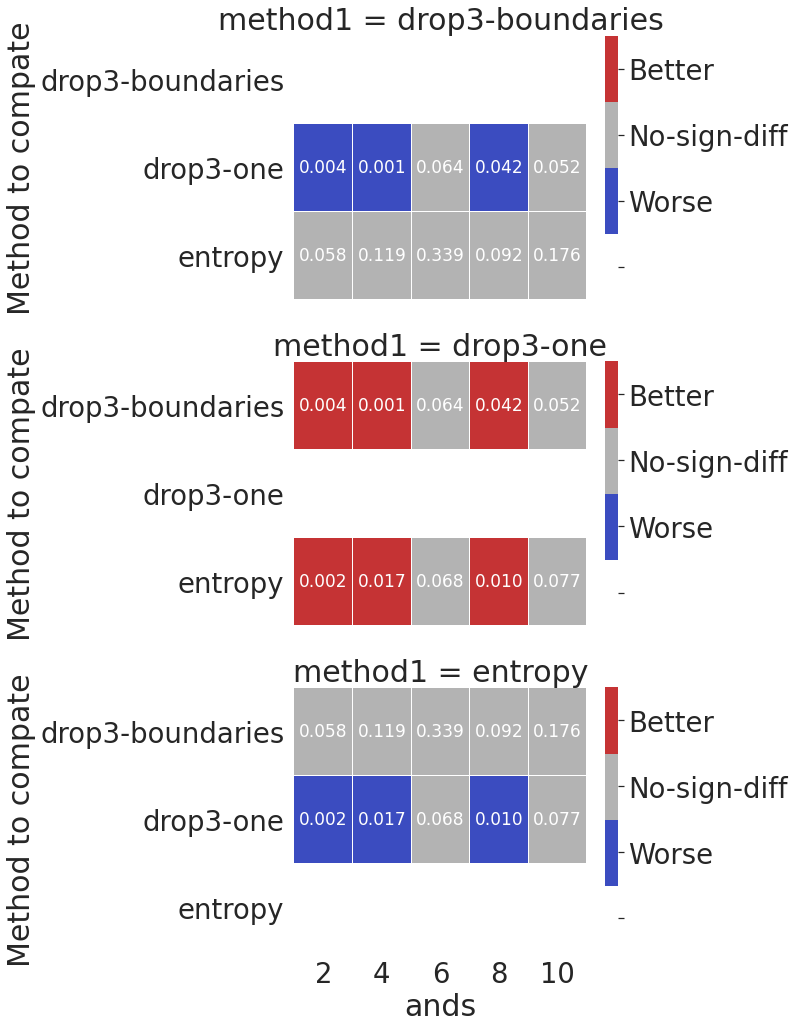

In [176]:
col_unique =  pairwise_winners['winner'].unique()

sns.set(font_scale=2.5, style='whitegrid',
        rc={'grid.color': '.6'})

value_to_int = {j:i for i,j in enumerate(col_unique)}
value_from_int = {i:j for i,j in enumerate(col_unique)}
pairwise_winners['winner_int'] = pairwise_winners.winner.replace(value_to_int)

c_bar_mapping = {j:True if i in [0,1,2] else False  for i,j in enumerate(pairwise_winners['method1'].unique())}
n = len(value_to_int)     

colors = {'Worse':'#3B4CC0', 'Better': '#C53334', 'No-sign-diff': '#B3B3B3', None: '#FFFF'}

cmap = sns.color_palette([colors[value_from_int[w]] for w in value_to_int.values()])

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    col = data['method1'].unique()[0]
    d = pd.pivot_table(data, index=args[1], columns=args[0], values=args[2], aggfunc= 'first')
    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    cbar = c_bar_mapping[col]
    ax = sns.heatmap(d, cbar = cbar,  **kwargs)

fg = sns.FacetGrid(pairwise_winners, row='method1', aspect = 2.3, height=5)
fg.map_dataframe(draw_heatmap, 'ands', "method2", 'winner_int', cmap=cmap, annot = False, linewidths=.1, vmin = 0, vmax=3)
fg.set_titles(col_template="{col_name}")

for i in [0,1,2]:
    colorbar = np.ravel(fg.axes)[i].collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))
fg.set_ylabels('Method to compate')

base_x = 0.5
base_y =  0.5
ands = pairwise_winners.ands.unique()
for m1, ax in fg.axes_dict.items():
        
        for n,a in enumerate(ands):
            for n_m2, m2 in  enumerate(fg.axes_dict.keys()):
                vp = pairwise_winners.loc[(pairwise_winners.method1==m1) & (pairwise_winners.method2==m2) & (pairwise_winners.ands == a), 'p'].values[0]
                ax.text(base_x+n,base_y+n_m2, f'{vp:.3F}', fontsize = 17, color = 'w', horizontalalignment='center', verticalalignment = 'center' )
plt.tight_layout()
fg.savefig(f"report/final_comparasion.png", dpi = 300)

In [149]:
pairwise_winners['vs'] = pairwise_winners.method1 + "\nvs\n" + pairwise_winners.method2
pairwise_winners['p'] = pairwise_winners.p.astype('float64')
pairwise_winners['p_min'] = 1- pairwise_winners.p.astype('float64')

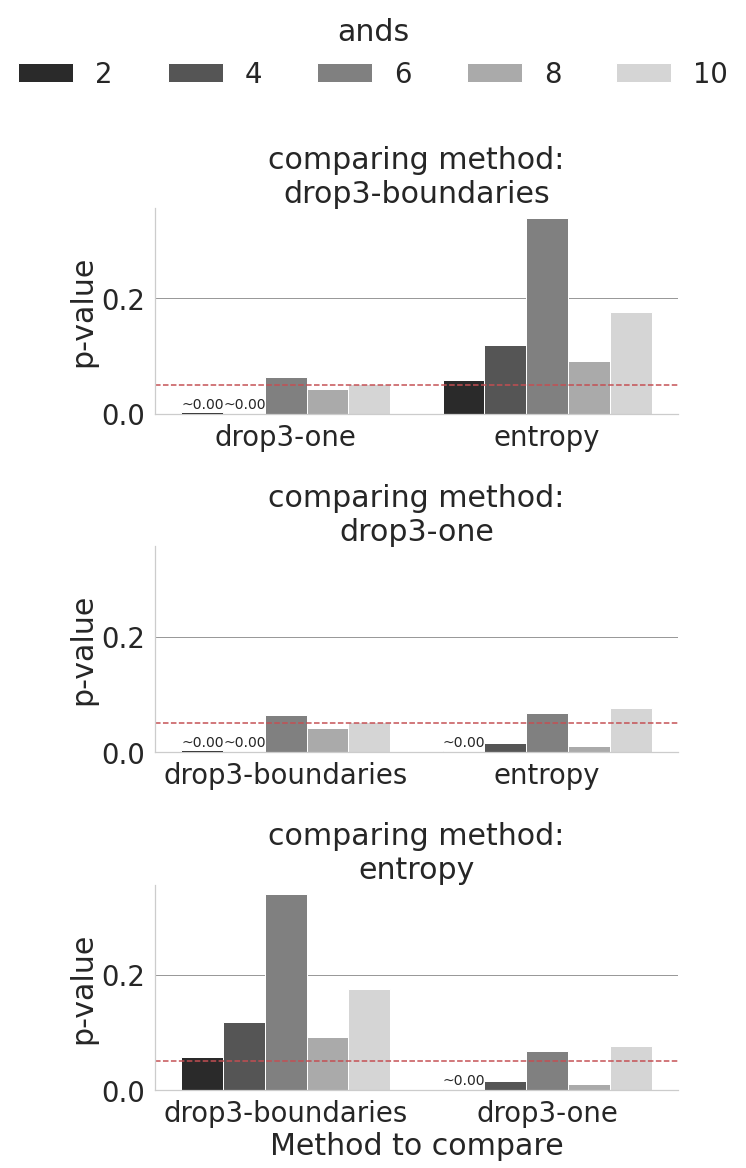

In [228]:
fg = sns.catplot(data = pairwise_winners.dropna(subset = ['p']), y='p', hue='ands', 
                 kind = 'bar', x = 'method2', aspect = 1.5, row = 'method1', sharex=False, palette='gist_gray', legend = True)
fg.refline(y=0.05, x=None, color = 'r')
sns.move_legend(fg, "lower center", bbox_to_anchor=(.5, 1), ncol=5, frameon=False)
fg.set_xlabels('Method to compare')
fg.set_ylabels('p-value')
fg.set_titles(row_template="comparing method:\n{row_name}")
# adding values when it is not visible
limit = 0.01
for ax in fg.axes.flat:
    for p in ax.patches:
        h = p.get_height()
        if h<limit:
            x = p.get_x()
            y = p.get_y()
            ax.annotate(xy =(x, 0.01), text = f"~{h:.2f}", fontsize = 14, ha = 'left')

plt.tight_layout()
fg.savefig(f"report/final_comparasion.png", dpi = 300)


In [60]:
measures = ['tp',
 'tn',
 'fp',
 'fn',
 'sensibility',
 'specificity',
 'precision',
 'accuracy',
 'F1',
 'Gmean',
 'wtdAcc',
 'balancedAcc',
 'mcc',
 'AreaROC',
 'timeIS',
 'timeLSH',
 'model_complexity',
 'Total Time',
 '% of samples']

In [61]:
mean_best_is = df_toplot[df_toplot.type=='test'].groupby(['database', 'lshMEthod', 'one_class_method', 'ands'])[measures].mean().reset_index()
to_table = mean_best_is.sort_values('Gmean', ascending = False).drop_duplicates(subset= 'database')
std_best = df_toplot[df_toplot.type=='test'].groupby(['database', 'lshMEthod', 'one_class_method', 'ands'])[measures].std().reset_index()
to_table = pd.merge(to_table, std_best, on =['database', 'lshMEthod', 'one_class_method', 'ands'], suffixes=("", "_std"))

In [62]:
to_table2 = mean_best_is.sort_values(['% of samples', 'Gmean'], ascending = [True, False]).drop_duplicates(subset= 'database')
to_table2 = pd.merge(to_table2, std_best, on =['database', 'lshMEthod', 'one_class_method', 'ands'], suffixes=("", "_std")).sort_values('database')

In [63]:
to_table = pd.concat([to_table, to_table2], ignore_index=True)

In [64]:
mean_best_no_is = best_no_is[best_no_is.type=='test'].groupby(['database'])[measuresNoIS].mean().reset_index()
std_best_no_is = best_no_is[best_no_is.type=='test'].groupby(['database'])[measuresNoIS].std().reset_index()
mean_best_no_is = pd.merge(mean_best_no_is, std_best_no_is, on = 'database', suffixes=("", "_std"))

In [65]:
to_table = pd.merge(to_table.reset_index(), mean_best_no_is, on = 'database', suffixes=("", "_baseline")).sort_values('index').drop('index', axis = 1)

In [66]:
to_table

,database,lshMEthod,one_class_method,ands,tp,tn,fp,fn,sensibility,specificity,precision,accuracy,F1,Gmean,wtdAcc,balancedAcc,mcc,AreaROC,timeIS,timeLSH,model_complexity,Total Time,% of samples,tp_std,tn_std,fp_std,fn_std,sensibility_std,specificity_std,precision_std,accuracy_std,F1_std,Gmean_std,wtdAcc_std,balancedAcc_std,mcc_std,AreaROC_std,timeIS_std,timeLSH_std,model_complexity_std,Total Time_std,% of samples_std,tp_baseline,tn_baseline,fp_baseline,fn_baseline,sensibility_baseline,specificity_baseline,precision_baseline,accuracy_baseline,F1_baseline,Gmean_baseline,wtdAcc_baseline,AreaROC_baseline,balancedAcc_baseline,mcc_baseline,tp_std_baseline,tn_std_baseline,fp_std_baseline,fn_std_baseline,sensibility_std_baseline,specificity_std_baseline,precision_std_baseline,accuracy_std_baseline,F1_std_baseline,Gmean_std_baseline,wtdAcc_std_baseline,AreaROC_std_baseline,balancedAcc_std_baseline,mcc_std_baseline
0,credit_card,RHF,drop3-one,2,86.6,56302.2,86.6,11.8,88.091862,99.846425,50.0,99.825811,63.769333,93.767056,91.618231,93.969144,0.662826,0.571567,21.566743,0.032404,500,21.599147,0.465842,2.966479,193.302095,2.966479,4.207137,3.821577,0.005155,0.0,0.006568,1.033828,2.057917,2.674251,1.909368,0.014619,0.020957,1.021220,0.004555,0.0,1.021399,0.012087,76.68,56857.92,76.68,21.72,78.020186,99.865306,50.000000,99.827450,60.931743,88.260466,84.573722,0.969177,88.942746,0.623739,3.081160,247.279866,3.081160,3.219397,2.252378,0.005710,0.000000,0.010112,0.682830,1.271597,1.577222,0.009964,1.127120,0.009038
2,pageblocks,RHF,drop3-one,10,109.6,875.2,109.6,2.2,98.023829,88.850762,50.0,89.797418,66.220927,93.321654,95.271908,93.437295,0.657417,0.753419,1.997460,0.009546,500,2.007006,15.463413,9.762172,42.020233,9.762172,0.836660,0.768510,1.165005,0.0,0.929177,0.175219,0.562087,0.499835,0.542628,0.004451,0.024646,0.566711,0.002568,0.0,0.565227,0.255382,96.88,970.36,96.88,14.92,86.612947,90.910017,50.000000,90.510983,63.372410,88.707959,87.902068,0.938149,88.761482,0.613024,7.044330,39.669888,7.044330,4.143787,3.784078,0.737937,0.000000,0.503191,1.013520,1.686942,2.488667,0.013402,1.636423,0.015467
4,gateway_credit_card,RHF,drop3-one,4,768.5,1289117.0,768.5,174.0,81.543434,99.940420,50.0,99.926984,61.989451,90.274275,87.062530,90.741927,0.638206,0.540337,371.414164,2.573720,1500,373.987884,0.301843,9.574271,1672.971209,9.574271,6.733003,0.420289,0.000804,0.0,0.001321,0.121130,0.232721,0.294415,0.210498,0.001650,0.003715,58.181292,0.389937,0.0,58.412110,0.001347,615.80,1621755.20,20.40,579.20,51.534765,99.998742,96.791129,99.963056,67.256659,71.786650,66.073958,0.757668,75.766753,0.706114,22.283004,681.013062,2.951216,22.784049,0.428979,0.000182,0.471908,0.001355,0.314543,0.298556,0.300254,0.002144,0.214437,0.002417
1,credit_card,RHF,drop3-one,4,85.4,56607.8,85.4,13.0,86.802435,99.849360,50.0,99.826733,63.437320,93.086851,90.716513,93.325898,0.657997,0.628379,18.437329,0.030924,500,18.468254,0.465402,4.098780,249.507916,4.098780,3.082207,2.933925,0.007306,0.0,0.006894,0.794079,1.579292,2.052424,1.464758,0.011215,0.022336,1.974367,0.001536,0.0,1.973776,0.008720,76.68,56857.92,76.68,21.72,78.020186,99.865306,50.000000,99.827450,60.931743,88.260466,84.573722,0.969177,88.942746,0.623739,3.081160,247.279866,3.081160,3.219397,2.252378,0.005710,0.000000,0.010112,0.682830,1.271597,1.577222,0.009964,1.127120,0.009038
5,gateway_credit_card,RHF,drop3-one,2,768.8,1285720.6,768.8,174.2,81.528868,99.940240,50.0,99.926753,61.985156,90.266064,87.052280,90.734554,0.638148,0.530226,367.903498,3.314043,750,371.217542,0.300657,10.756393,597.425979,10.756393,5.718391,0.461305,0.000850,0.0,0.001107,0.133819,0.255743,0.322908,0.230643,0.001812,0.001483,47.463227,1.591954,0.0,47.535158,0.001658,615.80,1621755.20,20.40,579.20,51.534765,99.998742,96.791129,99.963056,67.256659,71.786650,66.073958,0.757668,75.766753,0.706114,22.283004,681.013062,2.951216,22.784049,0.428979,0.000182,0.471908,0.001355,0.314543,0.298556,0.300254,0.002144,0.214437,0.002417
3,pageblocks,RHF,d

In [67]:
measure_to_table = [ 'Gmean', 'sensibility', 'specificity', 'F1', 'balancedAcc', 'mcc',]
factors = ['database', 'lshMEthod', 'one_class_method', 'ands']

In [68]:
def to_mean_std_cell(df, measures,  measure_as_factor, factors):
    table = df.copy()
    d = 2
    
    cols_to_table = []
    
    for c in measures:
        table[c] = table[c].round(d).astype('str') + "$\pm$" + table[f"{c}_std"].round(d).astype('str')
        table[f"{c}_baseline"] = table[f"{c}_baseline"].round(d).astype('str') + "$\pm$" + table[f"{c}_std_baseline"].round(d).astype('str')
        cols_to_table.append(c)
        cols_to_table.append(f"{c}_baseline")
    table[factors[-1]] = table[factors[-1]].round(d).astype('str')
    table[measure_as_factor] = table[measure_as_factor].round(d).astype('str') + "$\pm$" + table[f"{measure_as_factor}_std"].round(d).astype('str')

    table = table[factors+ [measure_as_factor] + cols_to_table]
    return(table)

In [69]:
table = to_mean_std_cell(to_table,measure_to_table, '% of samples', factors)

In [70]:
table.to_excel("table.xlsx", index = False)

## Data set reduction analysis

In [71]:
metric = 'Reduction of DataSet(%)'
combinations = list(itertools.product(ismet, lsh, ands))
data_list = [df_toplot.loc[
    (df_toplot.one_class_method ==  is_lsh_and[0]) 
    & (df_toplot.lshMEthod ==  is_lsh_and[1])
    & (df_toplot.ands ==  is_lsh_and[2])
    & (df_toplot.type=='test'), metric].values for is_lsh_and in combinations]

data_list_count = [len(c) for c in data_list]
min(data_list_count)

f, p, ranks, pivot = friedman_test(*[c[0:min(data_list_count)] for c in data_list])

ranks_df = pd.DataFrame(columns = ['is_method', "lsh", "ands", "rank"])
for i,c in enumerate(combinations):
    is_m, lsh_f, a_f = c
    ranks_df.loc[i, :] = [is_m, lsh_f,a_f, ranks[i]]

p=0.000000
Different distributions (reject H0)


In [72]:
np.round(f, 4)

114.0123

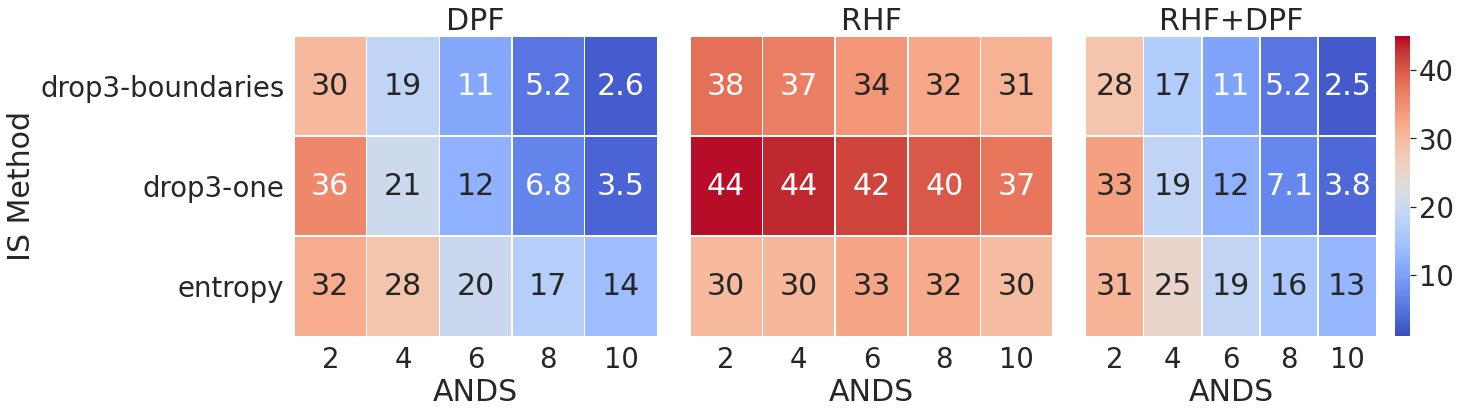

In [73]:
mapping = {'drop3-boundaries': 0, 'drop3-one': 1, 'entropy': 2}
c_bar_mapping = {'DPF': False, 'RHF': False, 'RHF+DPF': True}

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    col = data.lsh.unique()[0]
    d = pd.pivot_table(data, index=args[1], columns=args[0], values=args[2], aggfunc= 'first')
    cbar = c_bar_mapping[col]
    sns.heatmap(d, cbar = cbar, **kwargs)

ranks_df['IS Method'] = ranks_df.is_method
ranks_df['ANDS'] = ranks_df.ands
    
fg = sns.FacetGrid(ranks_df, col='lsh', aspect = 1, height=7)
fg.map_dataframe(draw_heatmap, 'ANDS', 'IS Method', 'rank', cmap = 'coolwarm', annot = True, vmin = 1.0, vmax=45,  linewidths=.5)
fg.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
fg.set_titles(col_template="{col_name}")

In [74]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    col = data.lshMEthod.unique()[0]
    d = pd.pivot_table(data, index=args[1], columns=args[0], values=args[2], aggfunc= 'first')
    cbar = c_bar_mapping[col]
    sns.heatmap(d, cbar = cbar, **kwargs)

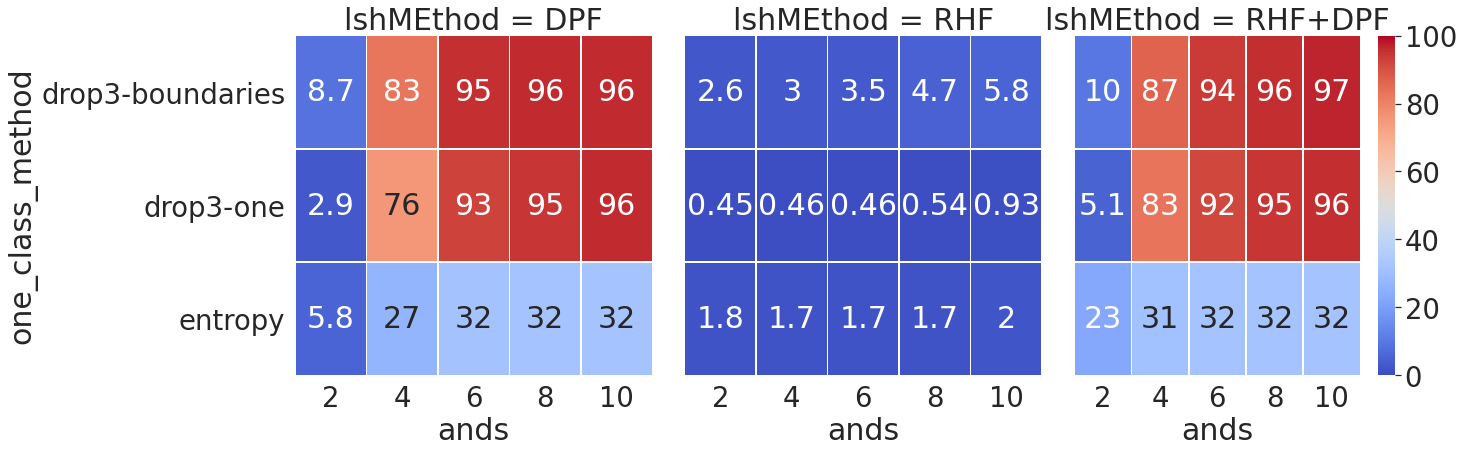

In [75]:
fg = sns.FacetGrid(df_toplot, col='lshMEthod', aspect = 1, height=7)
fg.map_dataframe(draw_heatmap, 'ands', 'one_class_method', '% of samples', cmap = 'coolwarm', annot = True, vmin = 0.0, vmax=100,  linewidths=.5)

In [84]:
sns.set(font_scale=3.0, style='whitegrid',
        rc={'grid.color': '.6'})

In [85]:
df = df_toplot[df_toplot.type == 'test'].copy()
df['Gmean'] = pd.qcut(df.Gmean, q = 4)
df.Gmean = df.Gmean.apply(lambda a: f'({a.left:.1f}, {a.right:.1f}]')

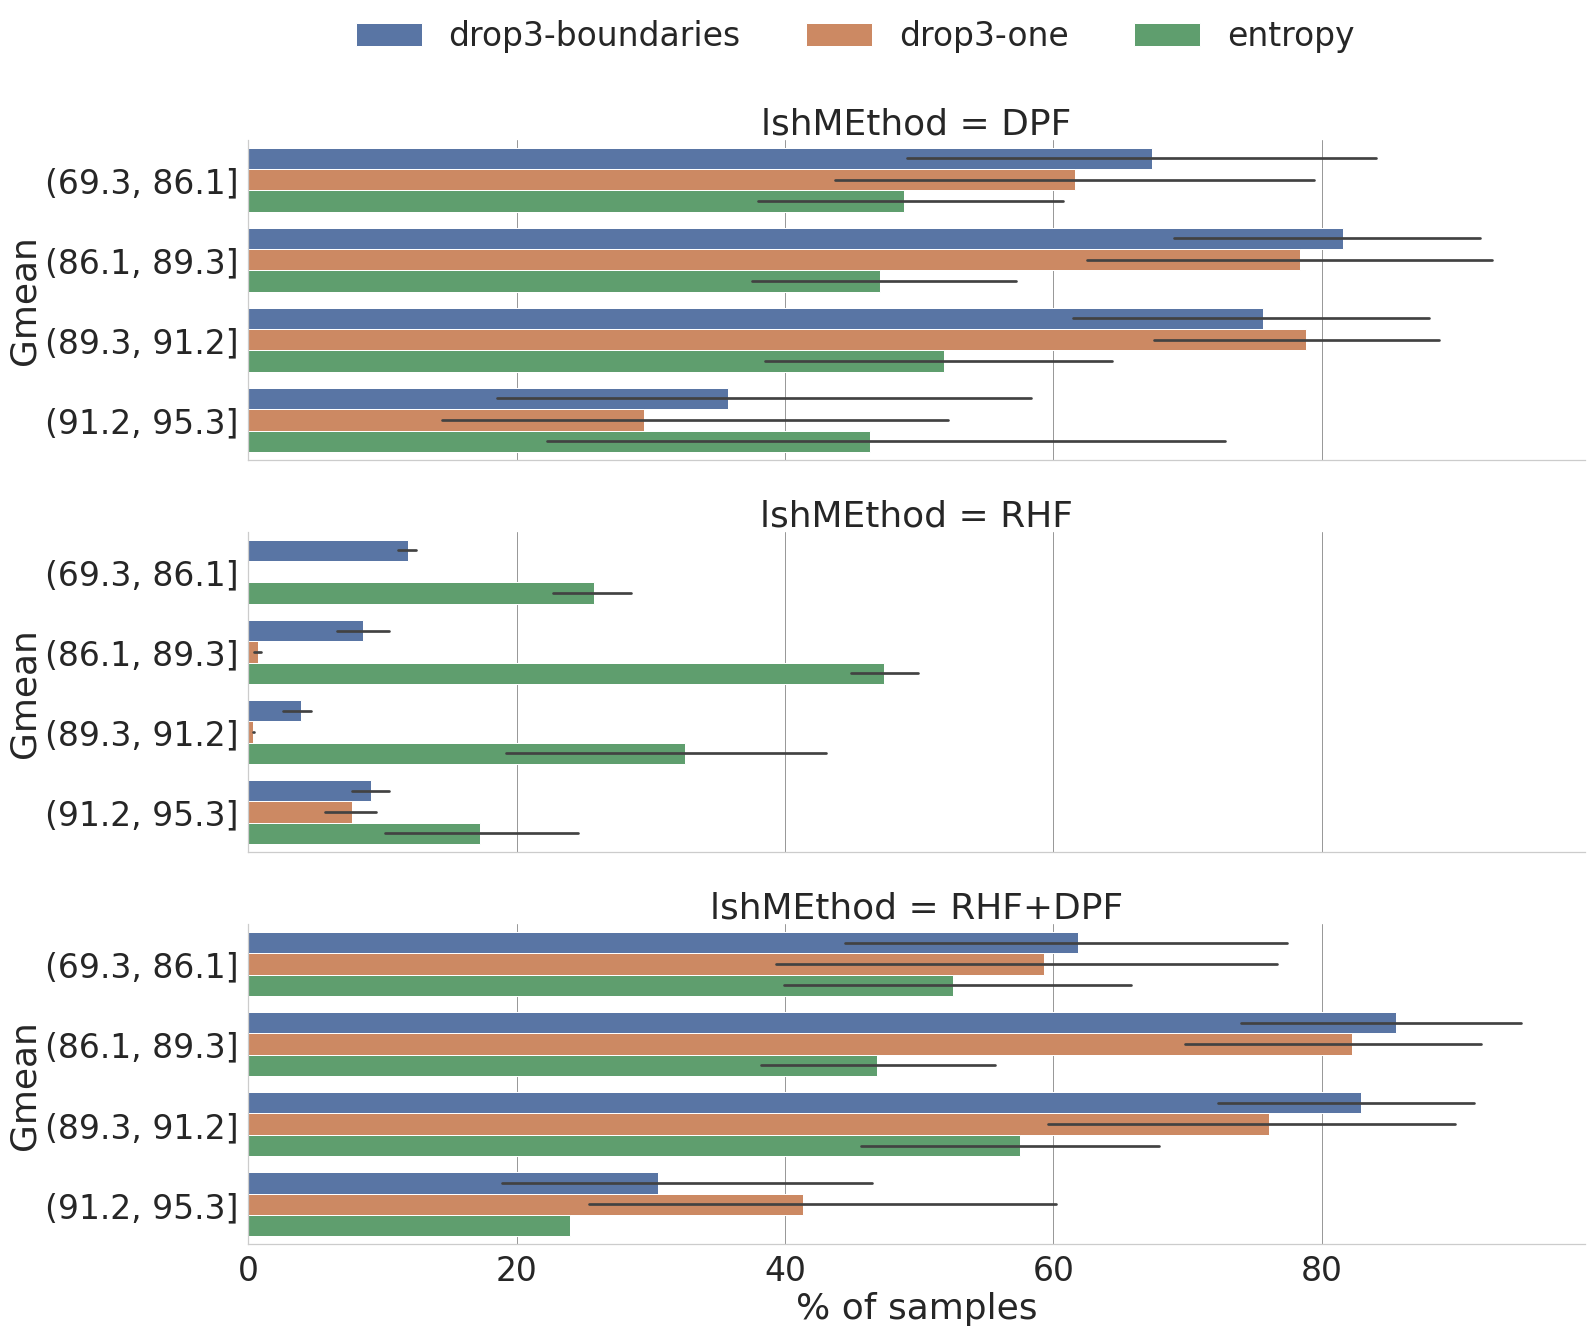

In [103]:
order = ['DPF', 'RHF', 'RHF+DPF']
f = sns.catplot(data =df , y = 'Gmean', hue = 'one_class_method', x ='% of samples', 
                row = 'lshMEthod', kind = 'bar', aspect = 1.5, row_order=order, height=6,
                legend = False,
               facet_kws = {'legend_out' : False})

f.add_legend(bbox_to_anchor=(0.18, 1.03,0.7, 0.03), loc='upper center', adjust_subtitles = True,  ncol=3)
f.set_titles(col_template="{row_name}")
plt.tight_layout()
f.savefig(f"report/gmean_reduction.png", dpi = 300,  bbox_inches='tight',  bbox_extra_artists=(f._legend,))